#  Assignment 2

In [1]:
import nltk
nltk.download("punkt", quiet=True)
nltk.download("punkt_tab", quiet=True)

True

In [2]:
import os
import pickle
import numpy as np
import pandas as pd

import nltk
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
try:
    import umap
except Exception as e:
    umap = None
    print("UMAP not available. If needed, install with: pip install umap-learn")

from sklearn.manifold import TSNE

nltk.download("punkt", quiet=True)


True

In [3]:
from gensim.models import KeyedVectors

def load_pkl_embeddings(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing file: {path}")
    with open(path, "rb") as f:
        data = pickle.load(f)
    emb = np.asarray(data["embeddings"], dtype=np.float32)
    word2idx = data["word2idx"]
    idx2word = data["idx2word"]
    return emb, word2idx, idx2word

pytorch_emb, pytorch_w2i, pytorch_i2w = load_pkl_embeddings("/Users/zhangzeyu/Downloads/西北大学/博一/stat359/word2vec_embeddings.pkl")
gensim_emb, gensim_w2i, gensim_i2w = load_pkl_embeddings("/Users/zhangzeyu/Downloads/西北大学/博一/stat359/word2vec_gensim_embeddings.pkl")
w2v_google = KeyedVectors.load("/Users/zhangzeyu/Downloads/西北大学/博一/stat359/word2vec-google-news-300.model")
fasttext = KeyedVectors.load("/Users/zhangzeyu/Downloads/西北大学/博一/stat359/fasttext-wiki-news-subwords-300.model")

print("Loaded:")
print("  PyTorch:", pytorch_emb.shape, "| vocab:", len(pytorch_w2i))
print("  Gensim :", gensim_emb.shape,  "| vocab:", len(gensim_w2i))
print("  GoogleNews:", w2v_google.vectors.shape, "| vocab:", len(w2v_google))
print("  FastText  :", fasttext.vectors.shape,   "| vocab:", len(fasttext))

Loaded:
  PyTorch: (253854, 100) | vocab: 253854
  Gensim : (18497, 100) | vocab: 18497
  GoogleNews: (3000000, 300) | vocab: 3000000
  FastText  : (999999, 300) | vocab: 999999


In [4]:
def tokenize_text(text):
    return word_tokenize(text.lower())

def cosine_sim(a, b, eps=1e-9):
    a = np.asarray(a, dtype=np.float32)
    b = np.asarray(b, dtype=np.float32)
    return float(a @ b / (np.linalg.norm(a) * np.linalg.norm(b) + eps))

def get_vec_pkl(word, emb, w2i):
    idx = w2i.get(word, None)
    if idx is None:
        return None
    return emb[idx]

def get_vec_keyed(word, kv):
    if word in kv:
        return kv.get_vector(word)
    return None

def sentence_embedding(text, get_word_vec_fn):
    toks = tokenize_text(text)
    vecs = []
    for t in toks:
        v = get_word_vec_fn(t)
        if v is not None:
            vecs.append(v)
    if len(vecs) == 0:
        return None, 0
    mat = np.stack(vecs, axis=0)
    return mat.mean(axis=0), len(vecs)

In [5]:
# List of sentences for comparison 
sentences = [
    "The cat sat on the mat.",
    "A dog is playing in the yard.",
    "I need to buy groceries today.",
    "The feline was resting on the rug.",
    "Canines enjoy outdoor activities.",
    "My shopping list includes milk and bread.",
    "The weather is beautiful today.",
    "Programming requires logical thinking."
]

# Query sentence
query = "My pet cat is sleeping on the carpet."

def run_sentence_similarity(label, get_word_vec_fn):
    q_emb, q_n = sentence_embedding(query, get_word_vec_fn)
    if q_emb is None:
        print(f"[{label}] Query has 0 in-vocab tokens. Can't compute.")
        return None

    rows = []
    for s in sentences:
        s_emb, s_n = sentence_embedding(s, get_word_vec_fn)
        if s_emb is None:
            sim = np.nan
        else:
            sim = cosine_sim(q_emb, s_emb)
        rows.append({
            "sentence": s,
            "cos_sim": sim,
            "n_tokens_used": s_n
        })

    df = pd.DataFrame(rows).sort_values("cos_sim", ascending=False)
    print(f"\n==== {label} ====")
    print(f"Query tokens used: {q_n}")
    display(df)
    return df

df_pytorch = run_sentence_similarity(
    "PyTorch-trained",
    lambda w: get_vec_pkl(w, pytorch_emb, pytorch_w2i)
)

df_gensim_text8 = run_sentence_similarity(
    "Gensim-trained (text8)",
    lambda w: get_vec_pkl(w, gensim_emb, gensim_w2i)
)

df_google = run_sentence_similarity(
    "Pretrained Word2Vec (Google News)",
    lambda w: get_vec_keyed(w, w2v_google)
)

df_fasttext = run_sentence_similarity(
    "Pretrained FastText",
    lambda w: get_vec_keyed(w, fasttext)
)



==== PyTorch-trained ====
Query tokens used: 8


,sentence,cos_sim,n_tokens_used
0,The cat sat on the mat.,0.784019,6
5,My shopping list includes milk and bread.,0.636755,7
1,A dog is playing in the yard.,0.570259,7
2,I need to buy groceries today.,0.542235,6
6,The weather is beautiful today.,0.489540,5
4,Canines enjoy outdoor activities.,0.476405,4
7,Programming requires logical thinking.,0.475373,4
3,The feline was resting on the rug.,0.348047,7



==== Gensim-trained (text8) ====
Query tokens used: 7


,sentence,cos_sim,n_tokens_used
0,The cat sat on the mat.,0.690595,6
1,A dog is playing in the yard.,0.602574,7
3,The feline was resting on the rug.,0.479223,5
5,My shopping list includes milk and bread.,0.473918,7
6,The weather is beautiful today.,0.469196,5
2,I need to buy groceries today.,0.176581,5
4,Canines enjoy outdoor activities.,0.071327,3
7,Programming requires logical thinking.,0.059729,4



==== Pretrained Word2Vec (Google News) ====
Query tokens used: 8


,sentence,cos_sim,n_tokens_used
3,The feline was resting on the rug.,0.779382,7
0,The cat sat on the mat.,0.736872,6
1,A dog is playing in the yard.,0.648278,6
5,My shopping list includes milk and bread.,0.496959,6
6,The weather is beautiful today.,0.431013,5
4,Canines enjoy outdoor activities.,0.428147,4
2,I need to buy groceries today.,0.371789,5
7,Programming requires logical thinking.,0.297923,4



==== Pretrained FastText ====
Query tokens used: 9


,sentence,cos_sim,n_tokens_used
3,The feline was resting on the rug.,0.924730,8
0,The cat sat on the mat.,0.911408,7
1,A dog is playing in the yard.,0.851180,8
5,My shopping list includes milk and bread.,0.834956,8
6,The weather is beautiful today.,0.809037,6
4,Canines enjoy outdoor activities.,0.650420,5
7,Programming requires logical thinking.,0.613466,5
2,I need to buy groceries today.,0.585847,7


All four models correctly assign high similarity to sentences related to cats/pets, showing that even the smallest models capture basic topical meaning. PyTorch-trained and Gensim-trained (text8) embeddings rank “The cat sat on the mat.” highest, but they fail to strongly associate “feline” to “cat”. Pretrained FastText and Pretrained Word2Vec (Google News) performs best overall, assigning very high similarity (>0.9) to both cat–feline sentences, showing strong semantic consistency.

In [6]:
animals = [
    'dog', 'cat', 'horse', 'cow',
    'lion', 'tiger', 'elephant', 'giraffe',
    'eagle', 'hawk', 'sparrow', 'penguin',
    'shark', 'whale'
]

foods = [
    'apple', 'orange', 'banana', 'grape',
    'bread', 'pasta', 'rice', 'potato',
    'chicken', 'beef', 'pork', 'fish',
    'coffee', 'tea', 'juice', 'water'
]


In [7]:
def collect_category_vectors(get_word_vec_fn, categories):
    """
    categories: dict[str, list[str]] like {"animals":[...], "foods":[...]}
    Returns: words_used, X (n,d), y_labels (n,)
    """
    words_used = []
    X = []
    y = []
    for cat, words in categories.items():
        for w in words:
            v = get_word_vec_fn(w)
            if v is None:
                continue
            words_used.append(w)
            X.append(v)
            y.append(cat)
    if len(X) == 0:
        return [], None, None
    return words_used, np.stack(X, axis=0), np.array(y)

def plot_2d_ax(ax, words, Z, y, title):
    color_map = {c:i for i,c in enumerate(sorted(set(y)))}
    colors = [color_map[c] for c in y]

    ax.scatter(Z[:,0], Z[:,1], c=colors, s=20)

    for w, (x, y_) in zip(words, Z):
        ax.text(x, y_, w, fontsize=6)

    ax.set_title(title, fontsize=9)
    ax.axis("off")


def run_tsne(X, random_state=0):
    n = X.shape[0]
    perplexity = min(10, max(2, (n // 3)))
    tsne = TSNE(n_components=2, init="random", learning_rate="auto",
                perplexity=perplexity, random_state=random_state)
    return tsne.fit_transform(X)

def run_umap(X, random_state=0):
    if umap is None:
        raise RuntimeError("UMAP not installed. Run: pip install umap-learn")
    reducer = umap.UMAP(n_components=2, n_neighbors=10, min_dist=0.2, random_state=random_state)
    return reducer.fit_transform(X)


/Users/zhangzeyu/Downloads/西北大学/博一/stat359/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/zhangzeyu/Downloads/西北大学/博一/stat359/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/zhangzeyu/Downloads/西北大学/博一/stat359/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/zhangzeyu/Downloads/西北大学/博一/stat359/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/zhangzeyu/Downloads/西北大学/博一/stat359/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

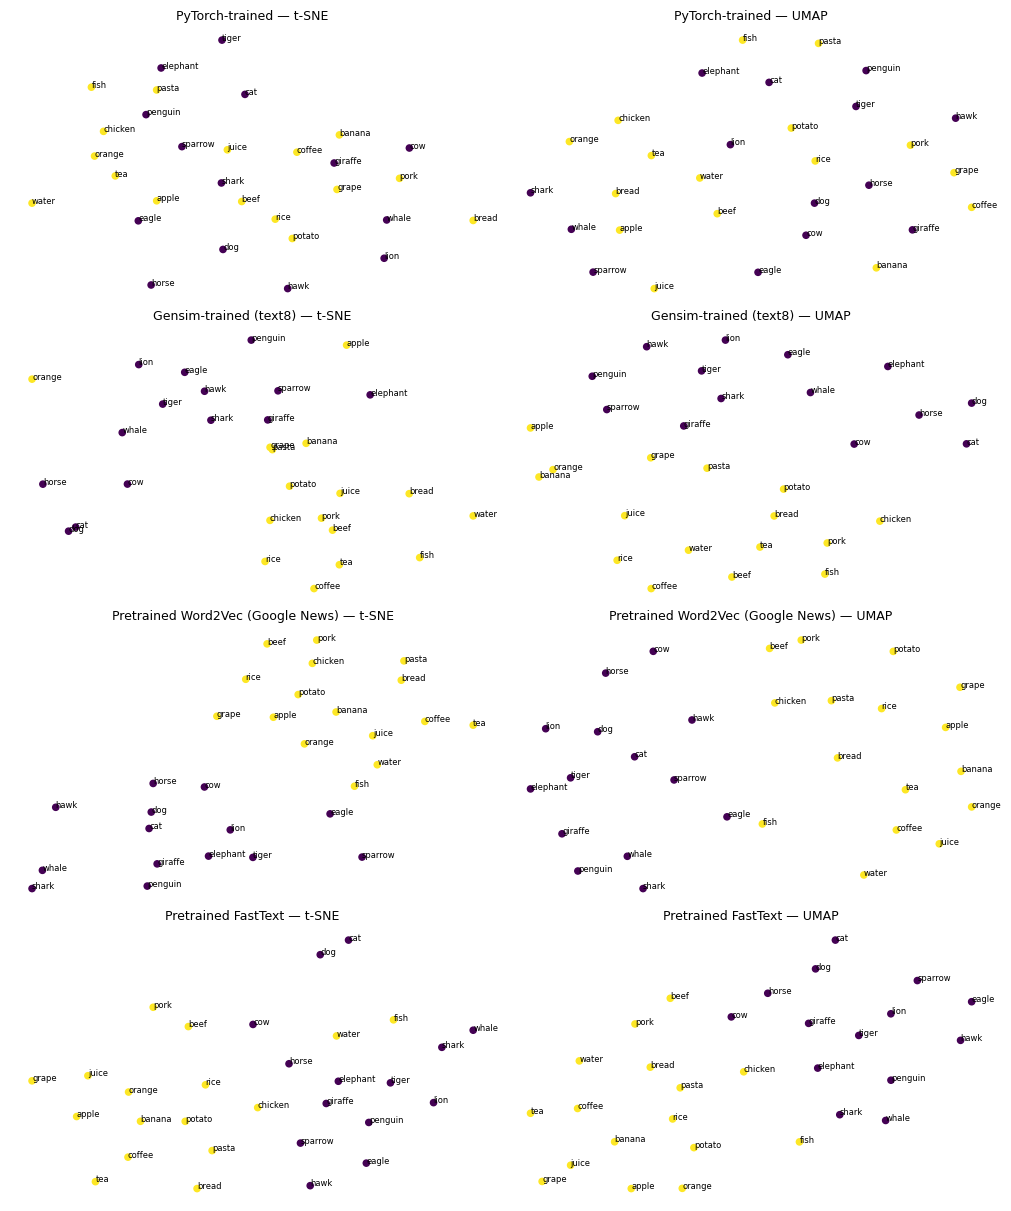

In [8]:
categories = {"animals": animals, "foods": foods}

sources = [
    ("PyTorch-trained",
     lambda w: get_vec_pkl(w, pytorch_emb, pytorch_w2i)),
    ("Gensim-trained (text8)",
     lambda w: get_vec_pkl(w, gensim_emb, gensim_w2i)),
    ("Pretrained Word2Vec (Google News)",
     lambda w: get_vec_keyed(w, w2v_google)),
    ("Pretrained FastText",
     lambda w: get_vec_keyed(w, fasttext)),
]

fig, axes = plt.subplots(
    nrows=4, ncols=2,
    figsize=(10, 12), 
    constrained_layout=True
)

for row, (name, getv) in enumerate(sources):
    words_used, X, y = collect_category_vectors(getv, categories)

    if X is None:
        axes[row, 0].set_title(f"{name} — t-SNE (no data)")
        axes[row, 1].set_title(f"{name} — UMAP (no data)")
        continue

    # t-SNE (left column)
    Z_tsne = run_tsne(X, random_state=0)
    plot_2d_ax(
        axes[row, 0],
        words_used, Z_tsne, y,
        f"{name} — t-SNE"
    )

    # UMAP (right column)
    if umap is not None:
        Z_umap = run_umap(X, random_state=0)
        plot_2d_ax(
            axes[row, 1],
            words_used, Z_umap, y,
            f"{name} — UMAP"
        )
    else:
        axes[row, 1].set_title(f"{name} — UMAP (not installed)")
        axes[row, 1].axis("off")

plt.show()

PyTorch-trained and Gensim-trained embeddings show weak separation between animals and foods, with noticeable overlap. Pretrained models exhibits the cleanest separation between animals and foods, especially in UMAP, with compact and semantically coherent clusters.

## Short Answer Questions

### (1)

The two pretrained models' embeddings performed best at capturing sentence meaning. They assigned the highest cosine similarities to semantically equivalent sentences involving cat and feline, with scores exceeding 0.9, indicating strong semantic alignment.

### (2)

Yes, the pretrained embeddings—especially FastText and Google News Word2Vec—were significantly better.
They demonstrated stronger synonym recognition, more stable similarity rankings, and clearer semantic clustering, whereas the custom-trained embeddings struggled with synonymy and semantic abstraction.

### (3)

Training data size, Vocabulary coverage, Subword modeling.

## AI Use Disclosure (Required)

If you used any AI-enabled tools (e.g., ChatGPT, GitHub Copilot, Claude, or other LLM assistants) while working on this assignment, you must disclose that use here. The goal is transparency-not punishment.

In your disclosure, briefly include:
- **Tool(s) used:** (name + version if known)
- **How you used them:** (e.g., concept explanation, debugging, drafting code, rewriting text)
- **What you verified yourself:** (e.g., reran the notebook, checked outputs/plots, checked shapes, read documentation)
- **What you did *not* use AI for (if applicable):** (optional)

You are responsible for the correctness of your submission, even if AI suggested code or explanations.

#### <font color="red">No</font>
